In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

'''
clear output dir
'''
# for dirname, _, filenames in os.walk('/kaggle/working'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         os.remove(os.path.join(dirname, filename))

/kaggle/input/mcm2022/prediction-model-maximum-likelihood-estimation.png
/kaggle/input/mcm2022/LBMA-GOLD.csv
/kaggle/input/mcm2022/prediction-model-analytical-solution.png
/kaggle/input/mcm2022/BCHAIN-MKPRU.csv
/kaggle/input/mcm2022/prediction-model-brownian-motion-ML-formula.png


'\nclear output dir\n'

# 美赛 2022

In [2]:
from IPython.display import Image
import os
def show_img(img_path, width, height):
    return Image(img_path, width=width, height=height)

## 清洗数据

In [3]:
'''
Import data
BCHAIN-MKPRU.csv  | 
LBMA-GOLD.csv
'''
import datetime
import numpy as np
import pandas as pd

def cal_date(day1, day2):
    date1 = datetime.datetime.strptime(day1[0:10], "%Y-%m-%d")
    date2 = datetime.datetime.strptime(day2[0:10], "%Y-%m-%d")
    num = abs((date2 - date1).days)
    return num

def normalize_date(date):
    # m/d/y -- 9/12/16
    idx1 = date.index('/')
    idx2 = date.rindex('/')
    year = '20' + date[idx2 + 1:]
    month = date[0:idx1]
    day = date[idx1 + 1:idx2]
    norm_date = '-'.join([year, month, day]) # 2016-9-12
    return norm_date

bitcoin_filepath = '../input/mcm2022/BCHAIN-MKPRU.csv'
gold_filepath = '../input/mcm2022/LBMA-GOLD.csv'

bitcoin_data = pd.read_csv(bitcoin_filepath)
print("Bitcoin Original Data\n", bitcoin_data)
gold_data = pd.read_csv(gold_filepath)
print("Gold Original Data\n", gold_data)

'''
Add column 'Id' and 'date' (which counts the number of days between today and the first day) into bitcoin_data
Complete some null data
''' 
for idx, row in bitcoin_data.iterrows():
    bitcoin_data.loc[idx, 'Date'] = normalize_date(bitcoin_data.loc[idx, 'Date'])
    if idx == 0:
        bitcoin_data.loc[idx, 'Id'] = 0
        bitcoin_data.loc[idx, 'date'] = 0
    else:
        bitcoin_data.loc[idx, 'Id'] = idx
        bitcoin_data.loc[idx, 'date'] = cal_date(bitcoin_data['Date'][idx], bitcoin_data['Date'][0])
    if np.isnan(bitcoin_data.loc[idx, 'Value']):
        print("There is a null point in " + str(row['Date']) + "th 'Value'")

'''
Add column 'Id' and 'date' (which counts the number of days between today and the first day) into gold_data
'''
for idx, row in gold_data.iterrows():
    gold_data.loc[idx, 'Date'] = normalize_date(gold_data.loc[idx, 'Date'])
    if idx == 0:
        gold_data.loc[idx, 'Id'] = 0
        gold_data.loc[idx, 'date'] = 0
    else:
        gold_data.loc[idx, 'Id'] = idx
        gold_data.loc[idx, 'date'] = cal_date(gold_data['Date'][idx], bitcoin_data['Date'][0])
    if np.isnan(gold_data.loc[idx, 'USD (PM)']):
        print("There is a null point in " + str(gold_data.loc[idx, 'Date']) + " 'USD'")

print("Bitcoin Data\n", bitcoin_data)
print("Gold Data\n", gold_data)

Bitcoin Original Data
          Date     Value
0     9/11/16    621.65
1     9/12/16    609.67
2     9/13/16    610.92
3     9/14/16    608.82
4     9/15/16    610.38
...       ...       ...
1821   9/6/21  51769.06
1822   9/7/21  52677.40
1823   9/8/21  46809.17
1824   9/9/21  46078.38
1825  9/10/21  46368.69

[1826 rows x 2 columns]
Gold Original Data
          Date  USD (PM)
0     9/12/16   1324.60
1     9/13/16   1323.65
2     9/14/16   1321.75
3     9/15/16   1310.80
4     9/16/16   1308.35
...       ...       ...
1268   9/6/21   1821.60
1269   9/7/21   1802.15
1270   9/8/21   1786.00
1271   9/9/21   1788.25
1272  9/10/21   1794.60

[1273 rows x 2 columns]
Bitcoin Data
            Date     Value      Id    date
0     2016-9-11    621.65     0.0     0.0
1     2016-9-12    609.67     1.0     1.0
2     2016-9-13    610.92     2.0     2.0
3     2016-9-14    608.82     3.0     3.0
4     2016-9-15    610.38     4.0     4.0
...         ...       ...     ...     ...
1821   2021-9-6  51769.

## 预测模型

### 几何布朗运动

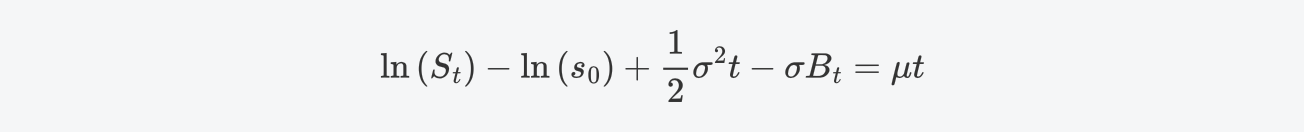

In [4]:
show_img('../input/mcm2022/prediction-model-brownian-motion-ML-formula.png', 500, 100)

1826 1826 1826


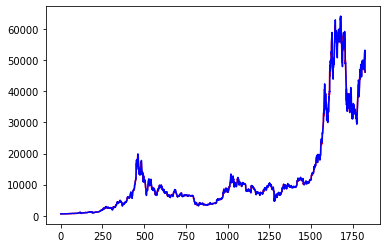

In [5]:
import math
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

'''
whether gold or bitcoin: 1 for gold, 2 for bitcoin
'''
ch = 2
gold_or_bitcoin_data = gold_data['USD (PM)']

filename = ''
if ch == 1: 
    gold_or_bitcoin_data = gold_data['USD (PM)']
    filename = 'gold'
elif ch == 2: 
    gold_or_bitcoin_data = bitcoin_data['Value']
    filename = 'bitcoin'

step_interval = 10 # window size
gold_or_bitcoin_data_len = len(gold_or_bitcoin_data) # length of bitcoin_data
gold_or_bitcoin_data_predict_value_list = [] # prediction
gold_or_bitcoin_data_sigma2_list = [] # sigma ^ 2: variance of ln_St
gold_or_bitcoin_data_mu_list = [] # mu: rate of return
next_prediction_interval = 1 # how many days to predict 
next_St_mean_list = [] # prediction values from current day to 'next_prediction_interval' days later
next_St_variance_list = []
R_list = []
B_t = 0.0

filename = '-'.join([filename, str(step_interval), str(next_prediction_interval)]) + '.csv'

for day in range(0, step_interval):
    gold_or_bitcoin_data_predict_value_list.append([gold_or_bitcoin_data[day]])
for day in range(step_interval, gold_or_bitcoin_data_len):
    X, y = [[0]], [0]
    start_day = day - step_interval
    ln_S0 = math.log(gold_or_bitcoin_data[start_day])
    for end_day in range(start_day + 1, day):
        ln_St = math.log(gold_or_bitcoin_data[end_day])
        t = end_day - start_day
        # compute sigma * sigma using formula
        sigma2 = 0
        for i in range(start_day, end_day):
            sigma2 = sigma2 + math.pow(math.log(gold_or_bitcoin_data[i + 1] / gold_or_bitcoin_data[i]), 2)
        sigma2 = sigma2 / t

        X.append([t])
        y.append(ln_St - ln_S0 + 0.5 * sigma2 * t - B_t * math.sqrt(sigma2))
    clf = linear_model.LinearRegression()
    clf.fit(X, y)
            
    # compute sigma * sigma using formula
    t = day - start_day
    sigma2 = 0
    for i in range(start_day, day):
        sigma2 = sigma2 + math.pow(math.log(gold_or_bitcoin_data[i + 1] / gold_or_bitcoin_data[i]), 2)
    sigma2 = sigma2 / t
    gold_or_bitcoin_data_sigma2_list.append(sigma2)
    
    # mu
    mu = clf.coef_[0]
    gold_or_bitcoin_data_mu_list.append(mu)
    
    # R
    R = math.exp(mu) - 1
    R_list.append(R)
    
    # next_St_mean
    next_St_mean = gold_or_bitcoin_data[day - 1] * np.vectorize(math.exp)(mu * np.linspace(1, next_prediction_interval, num=next_prediction_interval))
    next_St_mean_list.append(next_St_mean.tolist())
    gold_or_bitcoin_data_predict_value_list.append([next_St_mean[0]])
    
    # next_St_variance
    next_St_variance = [math.pow(gold_or_bitcoin_data[day - 1], 2) * math.exp(2 * mu) * (math.exp(sigma2) - 1)]
    for i in range(day + 1, day + next_prediction_interval):
        next_St_variance.append(math.pow(next_St_variance[i - day - 1], 2) * math.exp(2 * mu) * (math.exp(sigma2) - 1))
    next_St_variance_list.append(next_St_variance)

X = np.linspace(0, gold_or_bitcoin_data_len - 1, num=gold_or_bitcoin_data_len).tolist()
y = gold_or_bitcoin_data.tolist()
y_pred = gold_or_bitcoin_data_predict_value_list

print(len(X), len(y), len(y_pred))

plt.plot(X, y, 'r-', X, y_pred, 'b-')

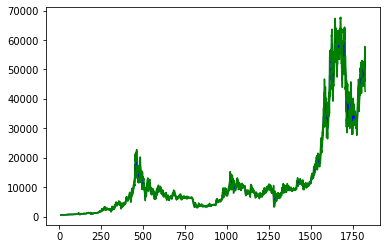

In [6]:
# 绘制 5 % 和 95 % 的误差图

X = np.linspace(step_interval, gold_or_bitcoin_data_len - 1, num=gold_or_bitcoin_data_len - step_interval).tolist()
y = gold_or_bitcoin_data.tolist()

y_pred = []
# for day in range(0, step_interval):
#     y_pred.append(gold_or_bitcoin_data[day])
for day in range(0, gold_or_bitcoin_data_len - step_interval):
    y_pred.append(next_St_mean_list[day][0])
# plt.plot(X, y, 'r-', X, y_pred, 'b-')

y_err = []
neg_err_list = []
pos_err_list = []
# for day in range(0, step_interval):
#     neg_err_list.append(0)
#     pos_err_list.append(0)
for day in range(0, gold_or_bitcoin_data_len - step_interval):
    neg_err = 1 - math.exp(-0.5 * gold_or_bitcoin_data_sigma2_list[day] - 1.96 * math.sqrt(gold_or_bitcoin_data_sigma2_list[day]))
    pos_err = math.exp(-0.5 * gold_or_bitcoin_data_sigma2_list[day] + 1.96 * math.sqrt(gold_or_bitcoin_data_sigma2_list[day])) - 1
    neg_err_list.append(y_pred[day] * (1 - neg_err))
    pos_err_list.append(y_pred[day] * (1 + pos_err))

y_err = [neg_err_list, pos_err_list]
# plt.errorbar(X, y_pred, yerr=y_err)
plt.plot(X, y_pred, 'b', X, neg_err_list, 'g', X, pos_err_list, 'g')


In [7]:
'''
save .csv file mu-formula, sigma^2, E(S_t), D(S_t), 5 % for S_t, 95 % for S_t
'''
import pandas as pd

dataframe = pd.DataFrame({'S_t(actual)': gold_or_bitcoin_data[step_interval:], 'E(S_t)': next_St_mean_list, 'D(S_t)': next_St_variance_list,
                          '5% S_t': neg_err_list, '95%': pos_err_list, 'R': R_list, 'sigma2(formular)': gold_or_bitcoin_data_sigma2_list, 'mu(formular)': gold_or_bitcoin_data_mu_list})

dataframe.to_csv(filename, index=False, sep=',')


In [8]:
# 该图已经废弃
# one_day = 400
# X = np.linspace(one_day - 1, one_day + next_prediction_interval - 1, next_prediction_interval + 1)
# y = gold_or_bitcoin_data.tolist()
# y_pred = next_St_mean_list[one_day]
# y_pred.insert(0, gold_or_bitcoin_data[one_day])
# plt.plot(X, y[one_day - 1:one_day + next_prediction_interval], 'r-', X, y_pred, 'b-')

In [9]:
# import numpy as np
# from scipy.stats import norm
# import matplotlib.pyplot as pyplot

# index = gold_or_bitcoin_data_len // 2
# meanAverage = gold_or_bitcoin_data_predict_value_list[index][0]    # typical value calculated beforehand
# standardDeviation = math.sqrt(sigma2s[index])    # typical value calculated beforehand

# x = np.linspace(start=int(meanAverage - 3 * standardDeviation), stop=int(meanAverage + 3 * standardDeviation), num=100)
# pyplot.plot(x, norm.pdf(x, meanAverage, standardDeviation))
# pyplot.show()

### 求参数优化方法（最大似然估计）

https://parsiad.ca/blog/2020/maximum-likelihood-estimation-of-gbm-parameters/

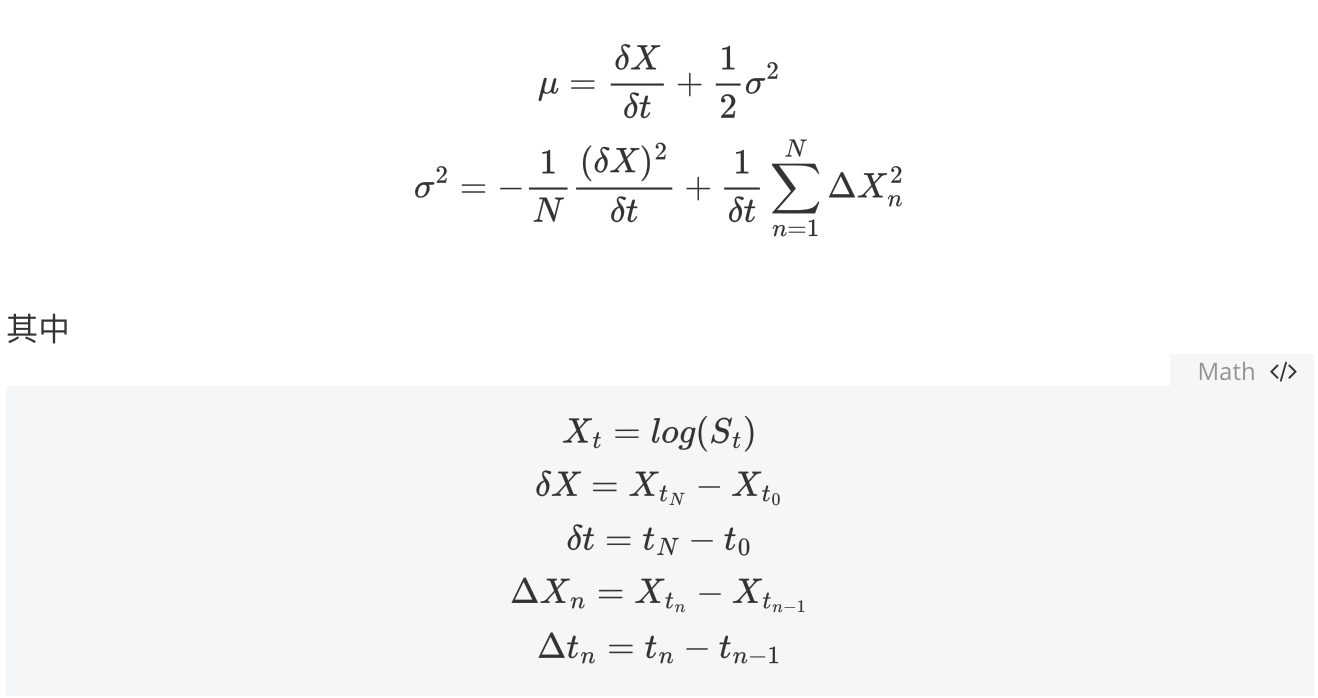

In [10]:
show_img('../input/mcm2022/prediction-model-maximum-likelihood-estimation.png', 500, 100)

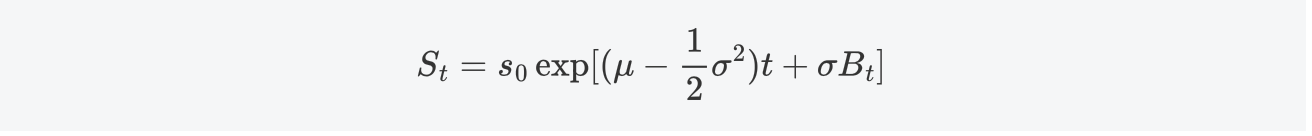

In [11]:
show_img('../input/mcm2022/prediction-model-analytical-solution.png', 500, 100)

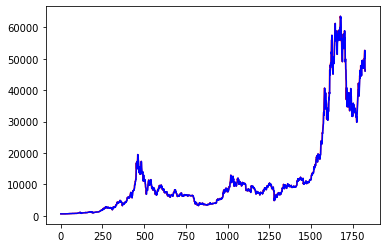

In [12]:
import math
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

step_interval = 10 # window size
gold_or_bitcoin_data_len = len(gold_or_bitcoin_data) # length of bitcoin_data
gold_or_bitcoin_data_predict_value_list = [] # prediction
gold_or_bitcoin_data_sigma2_list = [] # sigma ^ 2: variance of ln_St
mu_estimation = []
B_t = 0.0

for day in range(0, step_interval):
    gold_or_bitcoin_data_predict_value_list.append([gold_or_bitcoin_data[day]])
for day in range(step_interval, gold_or_bitcoin_data_len):
    end_day = day - 1
    start_day = day - step_interval
    delta_X = math.log(gold_or_bitcoin_data[end_day]) - math.log(gold_or_bitcoin_data[start_day])
    delta_t = end_day - start_day
    
    tot = 0
    for i in range(start_day + 1, end_day + 1):
        tot = tot + pow(math.log(gold_or_bitcoin_data[i]) - math.log(gold_or_bitcoin_data[i - 1]), 2)
    sigma2 = - (1 / (end_day - start_day)) * (math.pow(delta_X, 2) / delta_t) + (1 / delta_t) * tot
    mu = delta_X / delta_t + 0.5 * sigma2
    
    mu_estimation.append(mu)
    
    next_St_mean = gold_or_bitcoin_data[start_day] * math.exp((mu - 0.5 * sigma2) * (end_day - start_day) + math.sqrt(sigma2) * B_t)
    
    gold_or_bitcoin_data_predict_value_list.append([next_St_mean])

X = np.linspace(0, gold_or_bitcoin_data_len - 1, num=gold_or_bitcoin_data_len).tolist()
y = gold_or_bitcoin_data.tolist()
y_pred = gold_or_bitcoin_data_predict_value_list

plt.plot(X, y, 'r-', X, y_pred, 'b-')

In [13]:
'''
save .csv file add mu-estimation
'''
import pandas as pd

dataframe = pd.read_csv(filename)
dataframe['mu(estimate)'] = mu_estimation

dataframe.to_csv(filename, index=False, sep=',')
print("success")

success
